# Lessons from the first run-through of the experiment.

1. Most importantly, the zero noise runs take an extremely long time to run. (Eg. 4hr vs 20 min )

    - The practical lesson here is simple: don't run these as part of the sweeps.
    
    - Why this is the case is an interesting question. The network should be able to achieve very low, even zero, validation error just by ignoring or tuning to zero the U part of the network. On one hand, this means that there is always a little bit more performance that can be squeezed out, so it makes sense that training would take a while. On the other hand, the zero-noise case is also a really simple function to learn: it's just a null-op, so you would want a resaonable learning algorithm to be able to get it relatively quickly. This might be a case where drop-out could help.
    
    
2. On another practical note, the zero noise runs were also what required such a high patience in the early stopping. Most of the time for the other runs is occupied by patience epochs. Decreasing patience would thus result in massive speed-up for the experiments.


#### After running:

While running, I decreased the patience down to 50 epochs for speed reasons. It still took a long time to sweep on my laptop. Since I made the validation set fairly large, I think this (or even shorter patience) should be sufficient.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl

from models import UNet

In [2]:
# evaluate the performance of the trained networks
import os
import pandas as pd

performanceData = pd.DataFrame(columns=['N', 'M', 'noise', 'rep', 'loss'])

testModel = UNet()
testModel.setup()

lossFn = testModel.pixelLoss
noisyImages = testModel.data.test_noisy
groundTruthImages = testModel.data.test_base

for N in [10, 20, 50, 100]:
    for M in [10, 20, 50, 100]:
        for nr in [0.2, 0.4, 0.6, 0.8, 0.9]:
            for rep in [0,1,2]:
                print(N, M, nr, rep)
                dirName = f'lightning_logs/groundTruthSweep/N{N}M{M}nr{nr}rep{rep}/'
                fileName = os.listdir(dirName)[0]
                    
                currModel = UNet.load_from_checkpoint(dirName+fileName)
                loss = lossFn( currModel(noisyImages), groundTruthImages).item()
                
                row = pd.DataFrame(data={'N': [N], 'M': [M], 'noise': [nr], 'rep': [rep], 'loss': [loss]})
                
                performanceData = pd.concat( [performanceData, row], ignore_index=True)
                

10 10 0.2 0
10 10 0.2 1
10 10 0.2 2
10 10 0.4 0
10 10 0.4 1
10 10 0.4 2
10 10 0.6 0
10 10 0.6 1
10 10 0.6 2
10 10 0.8 0
10 10 0.8 1
10 10 0.8 2
10 10 0.9 0
10 10 0.9 1
10 10 0.9 2
10 20 0.2 0
10 20 0.2 1
10 20 0.2 2
10 20 0.4 0
10 20 0.4 1
10 20 0.4 2
10 20 0.6 0
10 20 0.6 1
10 20 0.6 2
10 20 0.8 0
10 20 0.8 1
10 20 0.8 2
10 20 0.9 0
10 20 0.9 1
10 20 0.9 2
10 50 0.2 0
10 50 0.2 1
10 50 0.2 2
10 50 0.4 0
10 50 0.4 1
10 50 0.4 2
10 50 0.6 0
10 50 0.6 1
10 50 0.6 2
10 50 0.8 0
10 50 0.8 1
10 50 0.8 2
10 50 0.9 0
10 50 0.9 1
10 50 0.9 2
10 100 0.2 0
10 100 0.2 1
10 100 0.2 2
10 100 0.4 0
10 100 0.4 1
10 100 0.4 2
10 100 0.6 0
10 100 0.6 1
10 100 0.6 2
10 100 0.8 0
10 100 0.8 1
10 100 0.8 2
10 100 0.9 0
10 100 0.9 1
10 100 0.9 2
20 10 0.2 0
20 10 0.2 1
20 10 0.2 2
20 10 0.4 0
20 10 0.4 1
20 10 0.4 2
20 10 0.6 0
20 10 0.6 1
20 10 0.6 2
20 10 0.8 0
20 10 0.8 1
20 10 0.8 2
20 10 0.9 0
20 10 0.9 1
20 10 0.9 2
20 20 0.2 0
20 20 0.2 1
20 20 0.2 2
20 20 0.4 0
20 20 0.4 1
20 20 0.4 2
20 20 0.6 0
2

Lesson 1: write a test loop to store this data during the training.

## Gross effects of each variable on loss

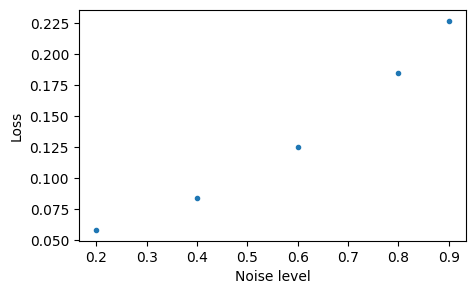

In [65]:
noiseEffect = performanceData.groupby('noise').agg(['mean', 'var'])['loss']
Neffect = performanceData.groupby('N').agg(['mean', 'var'])['loss']
Meffect = performanceData.groupby('M').agg(['mean', 'var'])['loss']

figsize(5,3)
ax1=plt.subplot(111)
ax1.errorbar(noiseEffect.index,  noiseEffect['mean'], noiseEffect['var'], fmt='.')
ax1.set_xlabel('Noise level');
ax1.set_ylabel('Loss');

Text(0.5, 0, 'M')

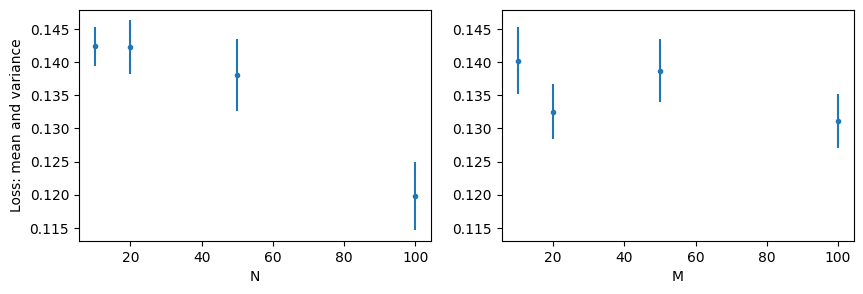

In [66]:
figsize(10,3)

ax2=plt.subplot(121)
ax2.errorbar(Neffect.index,  Neffect['mean'], Neffect['var'], fmt='.')
ax2.set_xlabel('N')
ax2.set_ylabel('Loss: mean and variance');
ax3=plt.subplot(122, sharey=ax2)
ax3.errorbar(Meffect.index,  Meffect['mean'], Meffect['var'], fmt='.')
ax3.set_xlabel('M')

Note that the error bars are variances, not error of the mean.

Obviously noise has a big effect, as we would expect. The impact of N and M are less clear. Much of this is probably swamped by the variance due to different noise levels, but it is curious to see M decrease at 20 relative to 10.

In [3]:
# control
from models import Control_Mode
from loadData import shotRandomNoise
from metrics import L1Loss

testData = testModel.data.test_base
controlPerformance = pd.DataFrame(columns=['M', 'noise', 'loss'])

controlModel = Control_Mode()

for M in [10, 20, 50, 100]:
    for noise in [0.2, 0.4, 0.6, 0.8, 0.9]:
        for rep in range(3):
            inds = [M*[i] for i in range(500)]
            noisy = shotRandomNoise(noise, testData[inds].view([500*M, 3, 32, 32]) )
            
            outs = controlModel.reconstruct(noisy.view([500, M, 3, 32, 32]))

            loss = L1Loss( outs, testData)
            
            row = pd.DataFrame(data={'M': [M], 'noise': [noise], 'loss': [loss]})
            controlPerformance = pd.concat( [controlPerformance, row], ignore_index=True)
            
            print(M, noise, rep)
    


10 0.2 0
10 0.2 1
10 0.2 2
10 0.4 0
10 0.4 1
10 0.4 2
10 0.6 0
10 0.6 1
10 0.6 2
10 0.8 0
10 0.8 1
10 0.8 2
10 0.9 0
10 0.9 1
10 0.9 2
20 0.2 0
20 0.2 1
20 0.2 2
20 0.4 0
20 0.4 1
20 0.4 2
20 0.6 0
20 0.6 1
20 0.6 2
20 0.8 0
20 0.8 1
20 0.8 2
20 0.9 0
20 0.9 1
20 0.9 2
50 0.2 0
50 0.2 1
50 0.2 2
50 0.4 0
50 0.4 1
50 0.4 2
50 0.6 0
50 0.6 1
50 0.6 2
50 0.8 0
50 0.8 1
50 0.8 2
50 0.9 0
50 0.9 1
50 0.9 2
100 0.2 0
100 0.2 1
100 0.2 2
100 0.4 0
100 0.4 1
100 0.4 2
100 0.6 0
100 0.6 1
100 0.6 2
100 0.8 0
100 0.8 1
100 0.8 2
100 0.9 0
100 0.9 1
100 0.9 2


## How does the neural network model compare to the mode control

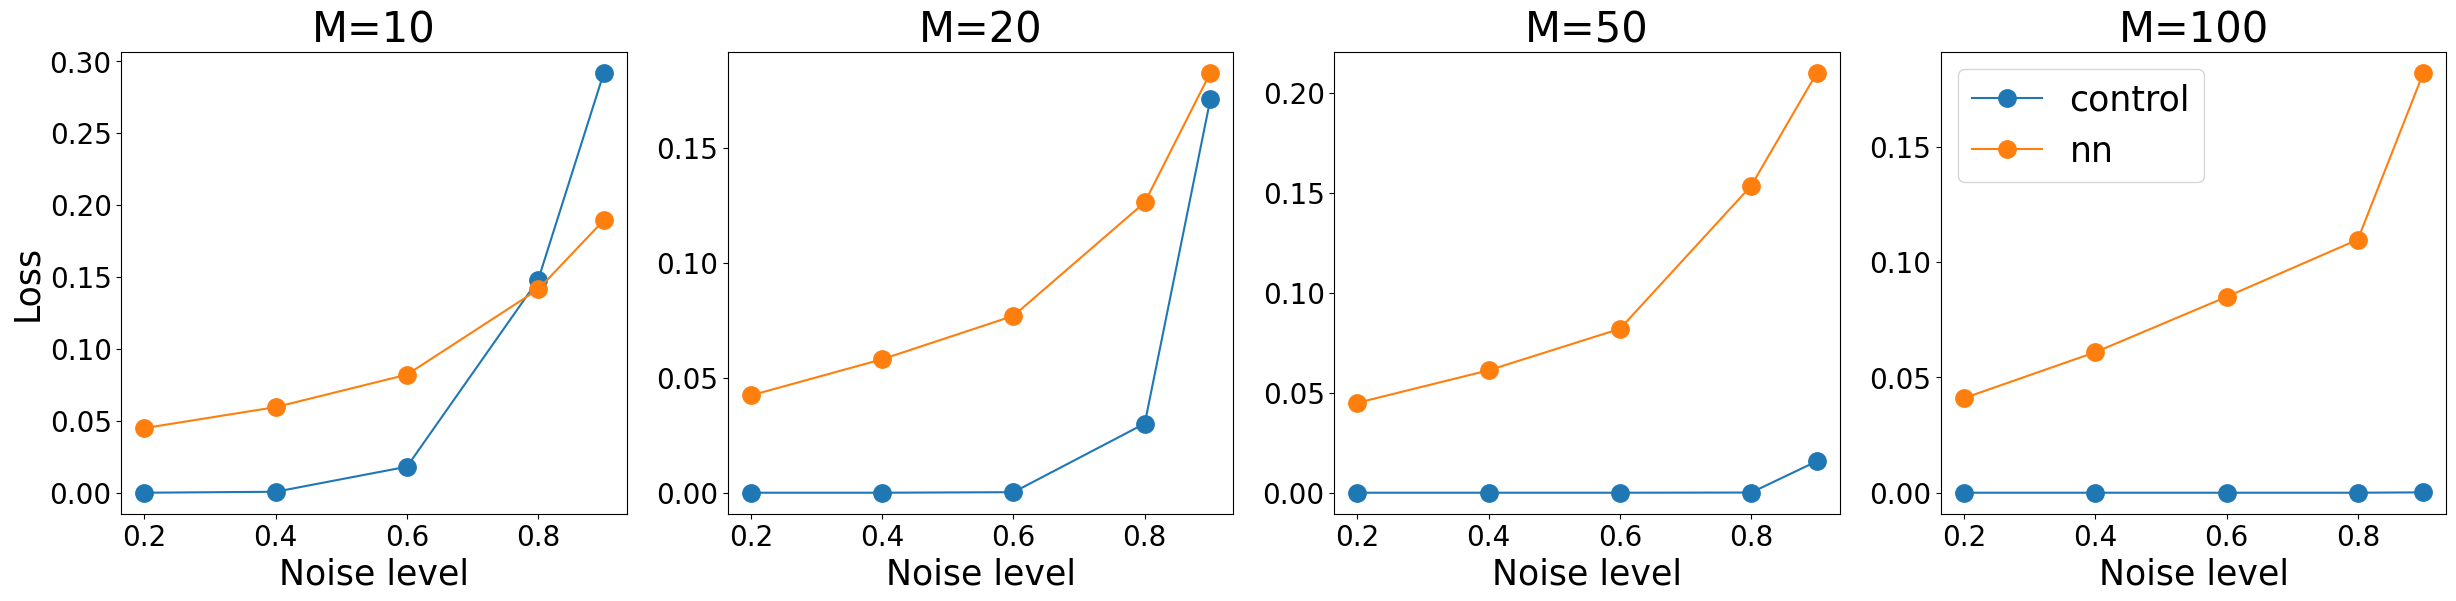

In [136]:
bestPerformance = performanceData.groupby(['M', 'noise']).agg('min')
controlAvg = controlPerformance.groupby(['M', 'noise']).mean()

mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
mpl.rc('font', size=25)

figsize(30, 6)
for i, M in enumerate( [10, 20, 50, 100] ):
    ax = plt.subplot(1, 4,i+1)
    ax.plot( controlAvg.loc[M].loss, '.-', markersize=25, label='control')
    
    ax.plot( bestPerformance.loc[M].loss, '.-', markersize=25, label='nn' )
    ax.set_xlabel('Noise level')
    ax.set_title(f'M={M}')
    if i == 0:
        ax.set_ylabel('Loss')
    
ax.legend()

## Initial conclusions

1. The neural network model is really unfit for this type of point randomization noise. It only becomes competitive with the control, which just evaluates the mode of the images it recieves, at very low sample numbers and very high noise. Note that that is mostly due to the poor performance of the control model. Additionally, note that we are taking the max performance over all different values of N, the number of clean images in the training set.
    * possible direction: change the noise mode.
        - something that has spatial structure would loose the simple control, but take advantage of the abilities of the NN
        - another possibility is point noise, but with a distribution that depends on the underlying value.


2. However, this comparison is a little bit unfair because the control model gets multiple noisy image samples during test time, while the neural networks get only one.
    * possible direction: allow the network to process multiple noisy images at once.
    
    

### what is the effect of the number of clean images?

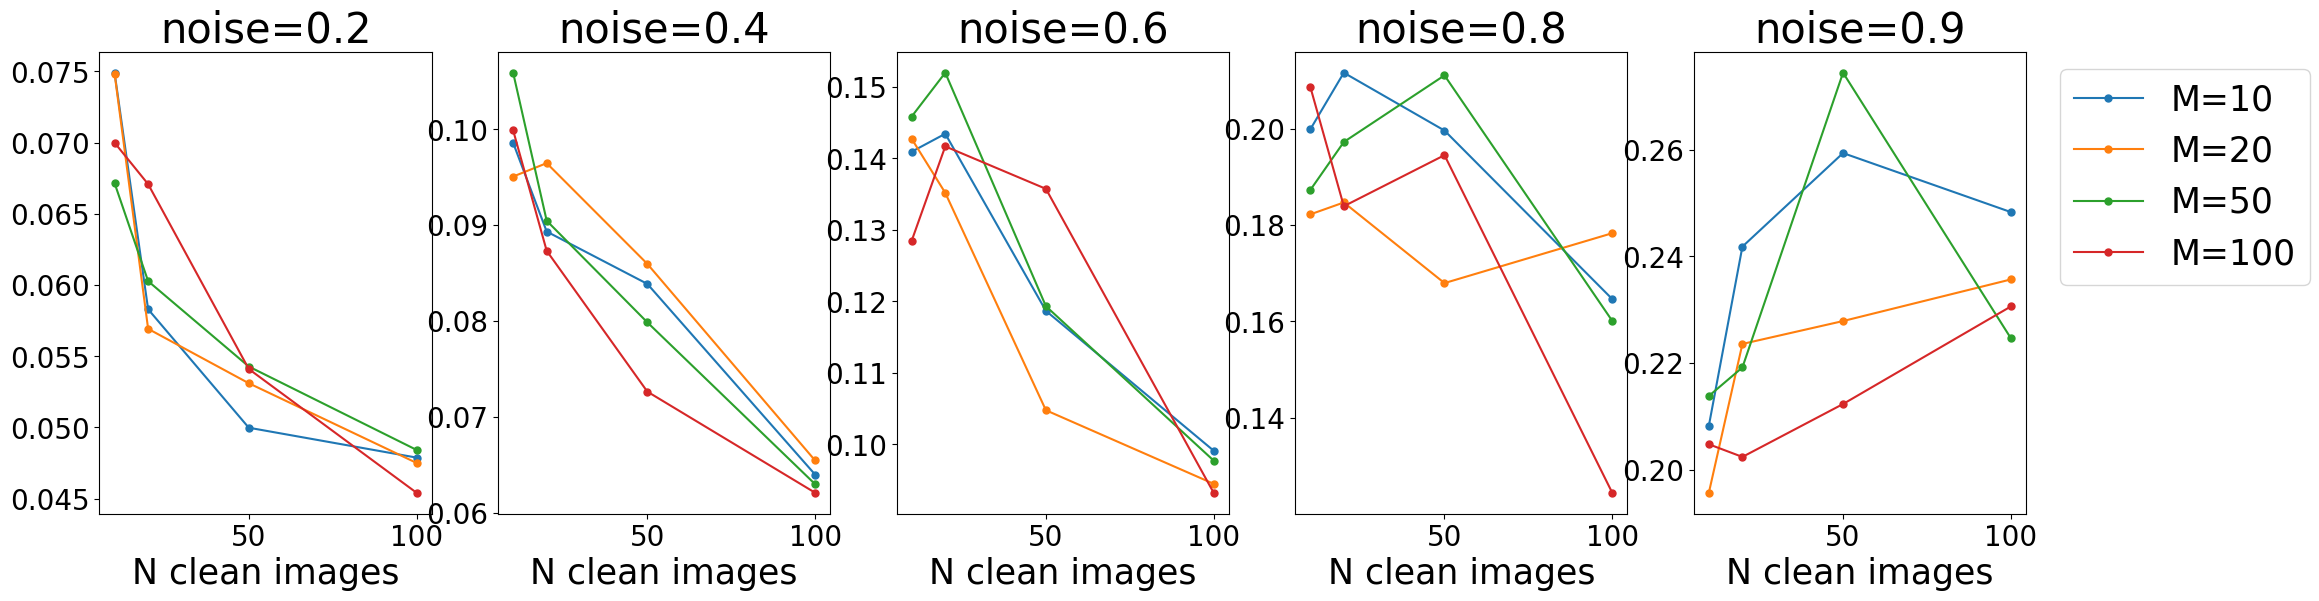

In [169]:
working = performanceData.groupby(['noise', 'M', 'N']).mean()['loss']

for i, noise in enumerate([0.2, 0.4, 0.6, 0.8, 0.9]):
    ax = plt.subplot(1, 6, i+1)
    ax.set_title(f'noise={noise}')
    ax.set_xlabel('N clean images')
    for M in [10, 20, 50, 100]:
        plt.plot(working.loc[noise, M], '.-', markersize=10, label=f'M={M}')
        

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [183]:
from statsmodels import api as sm
from statsmodels.formula.api import ols

linModel = ols( 'loss ~ C(noise) + C(noise)*C(N) + C(noise)*C(M)', data=performanceData).fit()

In [184]:
sm.stats.anova_lm(linModel)

,df,sum_sq,mean_sq,F,PR(>F)
C(noise),4.0,0.934792,0.233698,706.662494,1.168167e-118
C(N),3.0,0.020621,0.006874,20.784369,8.483253e-12
C(M),3.0,0.003663,0.001221,3.692054,1.277866e-02
C(noise):C(N),12.0,0.031141,0.002595,7.847041,5.595556e-12
C(noise):C(M),12.0,0.004656,0.000388,1.173183,3.042825e-01
Residual,205.0,0.067795,0.000331,NaN,NaN


### More conclusions:

As we can see in the ANOVA and visually in the plots above, the number of clean images has an obvious impact on the overall performance, while the number of sample images that we are training on is much less so. 
